# Keras - Lab

## Introduction

In this lab you'll once again build a neural network, but this time you will be using Keras to do a lot of the heavy lifting.


## Objectives

You will be able to:

- Build a neural network using Keras 
- Evaluate performance of a neural network using Keras 

## Required Packages

We'll start by importing all of the required packages and classes.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

## Load the data

In this lab you will be classifying bank complaints available in the `'Bank_complaints.csv'` file. 

In [2]:
# Import data
df = pd.read_csv('Bank_complaints.csv')

# Inspect data
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       60000 non-null  object
 1   Consumer complaint narrative  60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB
None


,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


As mentioned earlier, your task is to categorize banking complaints into various predefined categories. Preview what these categories are and what percent of the complaints each accounts for. 

In [7]:
# Your code here
print(df['Product'].value_counts())
print('\n', df['Product'].value_counts(normalize=True))

Student loan                   11404
Credit card                     9540
Consumer Loan                   9474
Mortgage                        8332
Bank account or service         8309
Credit reporting                6864
Checking or savings account     6077
Name: Product, dtype: int64

 Student loan                   0.190067
Credit card                    0.159000
Consumer Loan                  0.157900
Mortgage                       0.138867
Bank account or service        0.138483
Credit reporting               0.114400
Checking or savings account    0.101283
Name: Product, dtype: float64


## Preprocessing

Before we build our neural network, we need to do several preprocessing steps. First, we will create word vector counts (a bag of words type representation) of our complaints text. Next, we will change the category labels to integers. Finally, we will perform our usual train-test split before building and training our neural network using Keras. With that, let's start munging our data! 

## One-hot encoding of the complaints

Our first step again is to transform our textual data into a numerical representation. As we saw in some of our previous lessons on NLP, there are many ways to do this. Here, we'll use the `Tokenizer()` class from the `preprocessing.text` sub-module of the Keras package.   

As with our previous work using NLTK, this will transform our text complaints into word vectors. (Note that the method of creating a vector is different from our previous work with NLTK; as you'll see, word order will be preserved as opposed to a bag of words representation). In the below code, we'll only keep the 2,000 most common words and use one-hot encoding. 



In [8]:
# As a quick preliminary, briefly review the docstring for keras.preprocessing.text.Tokenizer
Tokenizer?

Init signature:
Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    document_count=0,
    **kwargs,
)
Docstring:     
Text tokenization utility class.

This class allows to vectorize a text corpus, by turning each
text into either a sequence of integers (each integer being the index
of a token in a dictionary) or into a vector where the coefficient
for each token could be binary, based on word count, based on tf-idf...

# Arguments
    num_words: the maximum number of words to keep, based
        on word frequency. Only the most common `num_words-1` words will
        be kept.
    filters: a string where each element is a character that will be
        filtered from the texts. The default is all punctuation, plus
        tabs and line breaks, minus the `'` character.
    lower: boolean. Whether to convert the texts to lowercase.
    split: str. Separator for word splitting.
    c

In [9]:
# ⏰ This cell may take about thirty seconds to run

# Raw text complaints
complaints = df['Consumer complaint narrative'] 

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=2000) 

# Fit it to the complaints
tokenizer.fit_on_texts(complaints) 

# Generate sequences
sequences = tokenizer.texts_to_sequences(complaints) 
print('sequences type:', type(sequences))

# Similar to sequences, but returns a numpy array
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary') 
print('one_hot_results type:', type(one_hot_results))

# Useful if we wish to decode (more explanation below)
word_index = tokenizer.word_index 

# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index)) 

# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

sequences type: <class 'list'>
one_hot_results type: <class 'numpy.ndarray'>
Found 50334 unique tokens.
Dimensions of our coded results: (60000, 2000)


## Decoding Word Vectors 

As a note, you can also decode these vectorized representations of the reviews. The `word_index` variable, defined above, stores the mapping from the label number to the actual word. Somewhat tediously, we can turn this dictionary inside out and map it back to our word vectors, giving us roughly the original complaint back. (As you'll see, the text won't be identical as we limited ourselves to top 2000 words.)

## Python Review / Mini Challenge

While a bit tangential to our main topic of interest, we need to reverse our current dictionary `word_index` which maps words from our corpus to integers. In decoding our `one_hot_results`, we will need to create a dictionary of these integers to the original words. Below, take the `word_index` dictionary object and change the orientation so that the values are keys and the keys values. In other words, you are transforming something of the form {A:1, B:2, C:3} to {1:A, 2:B, 3:C}. 

In [10]:
# Your code here
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

## Back to Decoding Our Word Vectors...

In [11]:
comment_idx_to_preview = 19
print('Original complaint text:')
print(complaints[comment_idx_to_preview])
print('\n\n')

# The reverse_index cell block above must be complete in order for this cell block to successively execute 
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[comment_idx_to_preview]])
print('Decoded review from Tokenizer:')
print(decoded_review)

Original complaint text:
I have already filed several complaints about AES/PHEAA. I was notified by a XXXX XXXX let @ XXXX, who pretended to be from your office, he said he was from CFPB. I found out this morning he is n't from your office, but is actually works at XXXX. 

This has wasted weeks of my time. They AES/PHEAA confirmed and admitted ( see attached transcript of XXXX, conversation at XXXX ( XXXX ) with XXXX that proves they verified the loans are not mine ) the student loans they had XXXX, and collected on, and reported negate credit reporting in my name are in fact, not mine. 
They conclued their investigation on XXXX admitting they made a mistake and have my name on soneone elses loans. I these XXXX loans total {$10000.00}, original amount. My XXXX loans I got was total {$3500.00}. We proved by providing AES/PHEAA, this with my original promissary notes I located recently, the XXXX of my college provided AES/PHEAA with their original shoeinf amounts of my XXXX loans which s

## Convert the Products to Numerical Categories

On to step two of our preprocessing: converting our descriptive categories into integers.

In [12]:
product = df['Product']

# Initialize
le = preprocessing.LabelEncoder() 
le.fit(product)
print('Original class labels:')
print(list(le.classes_))
print('\n')
product_cat = le.transform(product)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New product labels:')
print(product_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 7 binary columns, one for each of the categories.') 
product_onehot = to_categorical(product_cat)
print(product_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(product_onehot))

Original class labels:
['Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Credit card', 'Credit reporting', 'Mortgage', 'Student loan']


New product labels:
[6 6 6 ... 4 4 4]


One hot labels; 7 binary columns, one for each of the categories.
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


One hot labels shape:
(60000, 7)


## Train-test split

Now for our final preprocessing step: the usual train-test split. 

In [13]:
random.seed(123)
test_index = random.sample(range(1,10000), 1500)

test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

print('Test label shape:', np.shape(label_test))
print('Train label shape:', np.shape(label_train))
print('Test shape:', np.shape(test))
print('Train shape:', np.shape(train))

Test label shape: (1500, 7)
Train label shape: (58500, 7)
Test shape: (1500, 2000)
Train shape: (58500, 2000)


## Building the network

Let's build a fully connected (Dense) layer network with relu activation in Keras. You can do this using: `Dense(16, activation='relu')`. 

In this example, use two hidden layers with 50 units in the first layer and 25 in the second, both with a `'relu'` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 categories), we use a use a `'softmax'` classifier in order to output 7 class probabilities per case.  

In [14]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dense(25, activation = 'relu'))


# One layer with softmax activation 
model.add(layers.Dense(7, activation = 'softmax'))

## Compiling the model

Now, compile the model! This time, use `'categorical_crossentropy'` as the loss function and stochastic gradient descent, `'SGD'` as the optimizer. As in the previous lesson, include the accuracy as a metric.

In [15]:
# Compile the model
model.compile(
    optimizer='SGD',
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

## Training the model

In the compiler, you'll be passing the optimizer (SGD = stochastic gradient descent), loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples.

_Note:_ ⏰ _Your code may take about one to two minutes to run._

In [16]:
# Train the model 
history = model.fit(
    train,
    label_train,
    epochs = 120,
    batch_size=256,
)

Epoch 1/120
229/229 [==============================] - 1s 4ms/step - loss: 1.8752 - acc: 0.2567
Epoch 2/120
229/229 [==============================] - 1s 4ms/step - loss: 1.5590 - acc: 0.4840
Epoch 3/120
229/229 [==============================] - 1s 4ms/step - loss: 1.1707 - acc: 0.6342
Epoch 4/120
229/229 [==============================] - 1s 5ms/step - loss: 0.9286 - acc: 0.6879
Epoch 5/120
229/229 [==============================] - 1s 4ms/step - loss: 0.8043 - acc: 0.7150
Epoch 6/120
229/229 [==============================] - 1s 5ms/step - loss: 0.7349 - acc: 0.7324
Epoch 7/120
229/229 [==============================] - 2s 9ms/step - loss: 0.6911 - acc: 0.7450
Epoch 8/120
229/229 [==============================] - 1s 5ms/step - loss: 0.6600 - acc: 0.7542
Epoch 9/120
229/229 [==============================] - 1s 4ms/step - loss: 0.6361 - acc: 0.7623
Epoch 10/120
229/229 [==============================] - 1s 4ms/step - loss: 0.6170 - acc: 0.7685
Epoch 11/120
229/229 [=================

Recall that the dictionary `history` has two entries: the loss and the accuracy achieved using the training set.

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

## Plot the results

As you might expect, we'll use our `matplotlib` for graphing. Use the data stored in the `history_dict` above to plot the loss vs epochs and the accuracy vs epochs. 

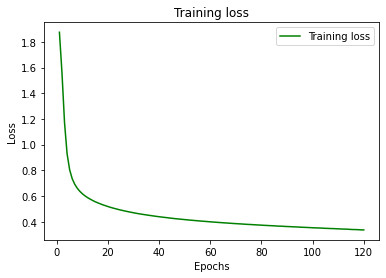

In [20]:
# Plot the loss vs the number of epoch

loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

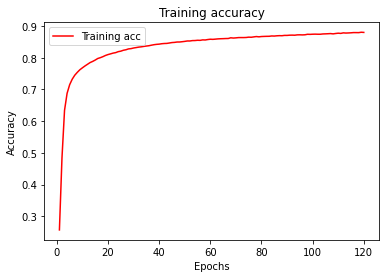

In [21]:
# Plot the training accuracy vs the number of epochs

acc = history_dict['acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems like we could just keep on going and accuracy would go up!

## Make predictions

Finally, it's time to make predictions. Use the relevant method discussed in the previous lesson to output (probability) predictions for the test set.

In [22]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(test)

## Evaluate Performance

Finally, print the loss and accuracy for both the train and test sets of the final trained model.

In [23]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(train, label_train)
results_train

1829/1829 [==============================] - 2s 1ms/step - loss: 0.3305 - acc: 0.8833


[0.33050113916397095, 0.88326495885849]

In [24]:
# Print the loss and accuracy for the test set 
results_test = model.evaluate(test, label_test)
results_test

47/47 [==============================] - 0s 2ms/step - loss: 0.2498 - acc: 0.9320


[0.24982813000679016, 0.9319999814033508]

We can see that the training set results are really good, and the test set results seem to be even better. In general, this type of result will be rare, as train set results are usually at least a bit better than test set results.

## Summary 

Congratulations! In this lab, you built a neural network thanks to the tools provided by Keras! In upcoming lessons and labs we'll continue to investigate further ideas regarding how to tune and refine these models for increased accuracy and performance.